# Experiment 10 - 2 zeroshot learning evaluation

In [1]:
import numpy as np
import torch
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from model import analysis
from importlib import reload
import tools
import pandas as pd
analysis = reload(analysis)
sns.set_style("whitegrid")

In [2]:
datadir = '../../data/model_results/experiment10/'
palette = sns.color_palette("Set2")


# Load data

In [46]:
simstart = 0 
simend = 40
nlayers = 3

#
df_adam0_combined = pd.read_csv(datadir + 'expt10_adam_zeroshot_' + str(nlayers) + 'layers_pretraining_2rulepretraining_simData' + str(simstart) + '.csv')
df_adam0_combined.insert(len(df_adam0_combined.columns),"Simulation",list(np.repeat(simstart,len(df_adam0_combined))),True)
df_adam0_combined.insert(len(df_adam0_combined.columns),"Layers",list(np.repeat(nlayers,len(df_adam0_combined))),True)
df_adam0_combined.insert(len(df_adam0_combined.columns),"Training",list(np.repeat('Combined',len(df_adam0_combined))),True)

for i in range(simstart+1,simend):
    ####

    #
    tmp = pd.read_csv(datadir + 'expt10_adam_zeroshot_' + str(nlayers) + 'layers_pretraining_2rulepretraining_simData' + str(i) + '.csv')
    tmp.insert(len(tmp.columns),"Simulation",list(np.repeat(i,len(tmp))),True)
    tmp.insert(len(tmp.columns),"Layers",list(np.repeat(nlayers,len(tmp))),True)
    tmp.insert(len(tmp.columns),"Training",list(np.repeat('Combined',len(tmp))),True)
    tmp['LogicAvg'] = tmp[['LogicPS1', 'LogicPS2']].mean(axis=1)
    tmp['SensoryAvg'] = tmp[['SensoryPS1', 'SensoryPS2']].mean(axis=1)
    tmp['MotorAvg'] = tmp[['MotorPS1', 'MotorPS2']].mean(axis=1)
    tmp['PSavg'] = tmp[['LogicAvg', 'SensoryAvg','MotorAvg']].mean(axis=1)
    df_adam0_combined = df_adam0_combined.append(tmp)
    
    
df_adam0_combined.Accuracy = df_adam0_combined.Accuracy.values*100.0
df_all = df_adam0_combined

## Plot PS as a function of depth for 'combined' pretraining

#### First load in vanilla model with CPRO task training (from expt 8)

In [47]:
depth_palette = ['#0099cc','#336699']


df_ps_combined = {}
df_ps_combined['Depth'] = []
df_ps_combined['DepthCount'] = []
df_ps_combined['Parallelism'] = []
df_ps_combined['Domain'] = []
df_ps_combined['Simulation'] = []

for i in range(simstart,simend):
    # Concept pretraining
    tmpdf = df_adam0_combined.loc[df_adam0_combined.Simulation==i]
    tmpdf = tmpdf.loc[tmpdf.NumPracticedTasks==0]
    for depth in range(1,nlayers+1):
        for rule in ['Sensory','Logic','Motor']:
            df_ps_combined['Simulation'].append(i)
            df_ps_combined['Depth'].append('Depth ' + str(depth))
            df_ps_combined['DepthCount'].append(depth)
            df_ps_combined['Domain'].append(rule)
            df_ps_combined['Parallelism'].append(tmpdf[rule + 'PS' + str(depth)].values[0])



df_ps_combined = pd.DataFrame(df_ps_combined)


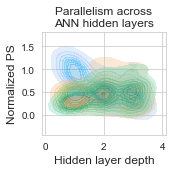

In [65]:
df_normalized = pd.DataFrame()
# Normalize all PS and decoding scores for each domain
for domain in ['Sensory','Logic','Motor']:
    tmpdf = df_ps_combined.loc[df_ps_combined.Domain==domain].copy()
    tmpps = (tmpdf.Parallelism.values - tmpdf.Parallelism.min())/np.max(tmpdf.Parallelism.max())
    tmpdf['Parallelism'] = tmpps
    df_normalized = df_normalized.append(tmpdf)
    
palette = [sns.color_palette('colorblind')[0],sns.color_palette('colorblind')[1],sns.color_palette('colorblind')[2]]


plt.figure(figsize=(2.5,2.5))
ax = sns.kdeplot(x="DepthCount",y="Parallelism",hue="Domain",hue_order=['Sensory','Logic','Motor',],data=df_normalized,palette=palette,alpha=.3,shade=True,legend=False)
plt.title('Parallelism across\nANN hidden layers',fontsize=12)
# plt.xticks([-5,1],['Input','Output'],fontsize=10,rotation=10)
plt.xticks(fontsize=10)
plt.xlabel('Hidden layer depth', fontsize=12)
plt.ylabel('Normalized PS',fontsize=12)
plt.yticks(fontsize=10)
# ax.legend_.set_bbox_to_anchor((1, .2))
# ax.legend_._set_loc(2)
# plt.setp(ax.get_legend().get_title(), fontsize='0')
# plt.setp(ax.get_legend().get_texts(), fontsize='8')
plt.tight_layout()
plt.savefig('ANNPSGradient.png',dpi=300)
